# Performing Text Classification with 1D CNNs + LSTM Keras Model

In [1]:
import numpy as np 
import pandas as pd
import re

from sklearn.utils import resample
from gensim.models import KeyedVectors

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D,Bidirectional,SpatialDropout1D
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dropout

from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report

C:\Users\risha\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.
C:\Users\risha\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\risha\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\risha\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a f

In [2]:
df_train=pd.read_csv("enron_train.txt",sep="\t",header=None)
df_test=pd.read_csv("enron_test.txt",sep="\t",header=None)

In [3]:
df_train.columns=["pred","content"]
df_test.columns=["pred","content"]

In [4]:
df_train['pred'].value_counts()

No     1938
Yes    1719
Name: pred, dtype: int64

In [5]:
df_test['pred'].value_counts()

No     683
Yes    309
Name: pred, dtype: int64

In [6]:
cList = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

In [7]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,?#]')
def clean_text(text):
    text = text.lower()
    text = text.strip()
    text = text.lstrip()   
    text = text.rstrip()
    text = expandContractions(text)
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = re.sub(r"https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+"," ",text)
    text = re.sub(r"\$\d+", " ",text)
    text = re.sub(r'[\w\.-]+@[\w\.-]+', " ",text)
    text = re.sub(r'\b(me|her|him|us|them|there|that)\b', " ",text)  
    return text

In [8]:
df_train["content"]= df_train["content"].astype(str).apply(clean_text)
df_test["content"]= df_test["content"].astype(str).apply(clean_text)

In [9]:
df_test.tail()

,pred,content
987,Yes,could you call on monday with further inform...
988,Yes,please call at your convenience to discuss.
989,Yes,please call the list around 200 to see if peop...
990,Yes,please give a call tomorrow to discuss briefly.
991,Yes,please review the below and lets discuss if th...


In [10]:
df_train.head()

,pred,content
0,No,>>> 1 contact now to make today!$link
1,No,act now to keep your life on the go!
2,No,choose between and dollars with up to 5 ye...
3,No,click above to earn today.
4,No,click here to receive your first today:


In [11]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
lemmatizer = WordNetLemmatizer()
# lemmatize string
def lemmatize_word(text):
    word_tokens = word_tokenize(text)
    # provide context i.e. part-of-speech
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in word_tokens if len(word)>2 and (word not in STOPWORDS)] 
    return lemmas

In [12]:
df_train['content'] = df_train['content'].apply(lemmatize_word)
df_test['content'] = df_test['content'].apply(lemmatize_word)

In [13]:
df_train.head()

,pred,content
0,No,"[contact, make, today, link]"
1,No,"[act, keep, life]"
2,No,"[choose, dollars, years, repay]"
3,No,"[click, earn, today]"
4,No,"[click, receive, first, today]"


In [14]:
MAX_NB_WORDS = 100
# Max number of words in each comment
MAX_SEQUENCE_LENGTH = 100 
# This is fixed.
EMBEDDING_DIM = 300
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df_train['content'].values)

In [15]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 5643 unique tokens.


In [16]:
X = tokenizer.texts_to_sequences(df_train['content'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH,padding='post',truncating='post')
print(X)
print('Shape of one feature tensor:', X.shape)

[[53  9 42 ...  0  0  0]
 [96  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [58  1 63 ...  0  0  0]
 [ 2 66 21 ...  0  0  0]
 [ 1 90 15 ...  0  0  0]]
Shape of one feature tensor: (3657, 100)


In [17]:
X_test = tokenizer.texts_to_sequences(df_test['content'].values)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH,padding='post',truncating='post')
print(X_test)
print('Shape of one feature tensor:', X_test.shape)

[[30 20  8 ...  0  0  0]
 [30 20 26 ...  0  0  0]
 [39  8  0 ...  0  0  0]
 ...
 [ 1  7 65 ...  0  0  0]
 [ 1 16  7 ...  0  0  0]
 [ 1 66 11 ...  0  0  0]]
Shape of one feature tensor: (992, 100)


In [18]:
Y = pd.get_dummies(df_train['pred']).values
print(Y)
print('Shape of one label tensor:', Y.shape)

[[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
Shape of one label tensor: (3657, 2)


In [19]:
Y_test=df_test["pred"]
Y_test=Y_test.map({"No":0,"Yes":1})

In [20]:
EMBEDDING_FILE = 'GoogleNews-vectors-negative300.bin.gz'

In [21]:
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [22]:
nb_words = min(MAX_NB_WORDS, len(word_index))+1
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
embedding_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [23]:
for (word, idx) in word_index.items():
    if word in word2vec.vocab and idx < MAX_NB_WORDS:
        embedding_matrix[idx] = word2vec.word_vec(word)
print(embedding_matrix)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.03100586  0.12109375  0.13964844 ... -0.23144531 -0.15527344
  -0.12402344]
 [ 0.03320312 -0.08984375 -0.29492188 ... -0.12695312  0.16113281
  -0.16015625]
 ...
 [-0.06152344 -0.08496094 -0.15039062 ... -0.06689453 -0.02197266
   0.05151367]
 [ 0.13769531  0.1640625   0.22070312 ...  0.0612793  -0.29296875
   0.04272461]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [24]:
X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)

(3291, 100) (3291, 2)
(366, 100) (366, 2)


In [25]:
model = Sequential()

#We load this embedding matrix into an Embedding layer. Note that we set trainable=False to prevent the weights from being updated during training.
model.add(Embedding(len(embedding_matrix), EMBEDDING_DIM, weights=[embedding_matrix], 
                            input_length=MAX_SEQUENCE_LENGTH, trainable=False))
#While 2D CNNs are used for image and video processing, 1D CNNs are used for natural language processing (NLP)
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(300)))
model.add(Dropout(0.2))

model.add(Dense(2, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


In [26]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          30300     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 32)           28832     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 32)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 600)               799200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 600)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                

In [27]:
early_stop = EarlyStopping(monitor='val_loss', patience=2,min_delta=0.0001)
#model_checkpoint = ModelCheckpoint(]\ ',monitor='val_loss',save_best_only=True,save_weights_only=True)

hist = model.fit(X_train, Y_train, \
        validation_data=(X_val, Y_val), \
        epochs=5, batch_size=64, shuffle=True, \
        callbacks=[early_stop])

Instructions for updating:
Use tf.cast instead.
Train on 3291 samples, validate on 366 samples
Epoch 1/5
3291/3291 [==============================] - 42s 13ms/step - loss: 0.6172 - acc: 0.6729 - val_loss: 0.5407 - val_acc: 0.7240
Epoch 2/5
3291/3291 [==============================] - 32s 10ms/step - loss: 0.5444 - acc: 0.7381 - val_loss: 0.5337 - val_acc: 0.7555
Epoch 3/5
3291/3291 [==============================] - 35s 11ms/step - loss: 0.5181 - acc: 0.7519 - val_loss: 0.5298 - val_acc: 0.7459
Epoch 4/5
3291/3291 [==============================] - 32s 10ms/step - loss: 0.4932 - acc: 0.7724 - val_loss: 0.5547 - val_acc: 0.7363
Epoch 5/5
3291/3291 [==============================] - 32s 10ms/step - loss: 0.4723 - acc: 0.7838 - val_loss: 0.5404 - val_acc: 0.7541


In [28]:
import matplotlib.pyplot as plt

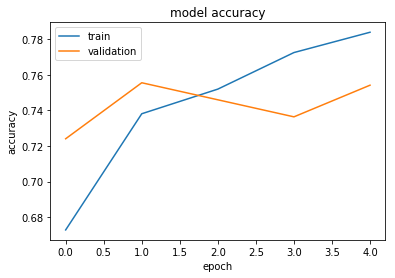

In [29]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

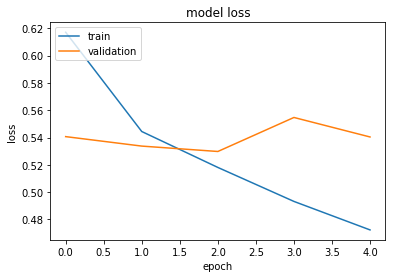

In [30]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [31]:
labels_pred = model.predict(X_test)
#labels_pred1 = labels_pred.ravel()
#accuracy = accuracy_score(Y_test, labels_pred)
#print("Accuracy: %.2f%%" % (accuracy*100))
df_test = pd.DataFrame(labels_pred,columns=["zero","one"])

In [32]:
df_test['max'] = np.where(df_test['zero']> df_test['one'],0,1)

# Output from LSTM + CNN Model, showing prediction scores for both Zero & One Label, and taking the maximum value from both the columns.

In [33]:
df_test

,zero,one,max
0,0.889504,0.110719,0
1,0.838516,0.160975,0
2,0.603763,0.391870,0
3,0.765933,0.231216,0
4,0.866057,0.133299,0
5,0.778265,0.225096,0
6,0.558309,0.438863,0
7,0.885429,0.111635,0
8,0.793372,0.203932,0
9,0.535951,0.463917,0


# LSTM Model Achieves Test Set Accuracy of 70.46%

In [34]:
accuracy = accuracy_score(df_test['max'],Y_test)
print("Test Set Accuracy: %.2f%%" % (accuracy*100))

Test Set Accuracy: 73.08%
